In [1]:
import torch as t
import matplotlib.pyplot as plt

In [3]:
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Training as Training
import Controls as Controls
import Evolvers as Evolvers

In [4]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Training)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [252]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	30,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  20,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [253]:
exp_path = os.path.join(dir_path,'Plotting','tmp_UE0s')
params_dict.update({"exp_path":exp_path})

In [254]:
class QTrotter(t.nn.Module, Systems.Periodic_System, Controls.ConstrainedPulse, Evolvers.QTrotter, Plotting.Plotter):
    def __init__(self,params_dict):
        super().__init__()
        self.params_dict = params_dict
        # self.alphas = alphas
        # self.control = control
        super(t.nn.Module,self).__init__()
        return

    def forward(self):
        H = self.get_H(self.activation_func(self.times),self.get_control())
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
QT = QTrotter(params_dict)

I added a factor half to the cosines


In [255]:
def phi_potential(phiXX,phiYY,alpha=1):
    return -QT.EJ*(t.cos(phiXX) + t.cos(phiYY) + alpha*t.cos(phiXX - phiYY - QT.phi_ext.real))

def get_eigvecs(alpha,u):
    H = QT.get_H(alphas=t.tensor([alpha]),control=t.tensor([u])).squeeze()
    eigvals, eigvecs = t.linalg.eigh(H)
    return eigvecs.T.view(eigvals.shape[0],QT.NHilbert,QT.NHilbert)

def get_eig(alpha,u):
    H = QT.get_H(alphas=t.tensor([alpha]),control=t.tensor([u])).squeeze()
    eigvals, eigvecs = t.linalg.eigh(H)
    return eigvals, eigvecs.T.view(eigvals.shape[0],QT.NHilbert,QT.NHilbert)

def q_to_phi(qstate):
    return t.fft.fftshift(t.fft.ifft2(t.fft.ifftshift(qstate)))

In [256]:
q = t.arange(-QT.q_max,QT.q_max+1,1)
XX, YY = t.meshgrid(q,q)

phi = t.linspace(-t.pi,t.pi,q.shape[0])
# phiXX, phiYY = t.meshgrid(t.fft.fftshift(t.fft.fftfreq(21,1)*t.pi),t.fft.fftshift(t.fft.fftfreq(21,1)*t.pi))
phiXX, phiYY = t.meshgrid(phi,phi)

In [202]:
eigvals, eigvecs = get_eig(1,0)

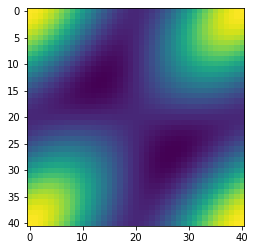

In [192]:
plt.imshow(phi_potential(phiXX,phiYY,1).T.flip(0))

[(-100.0, -40.0)]

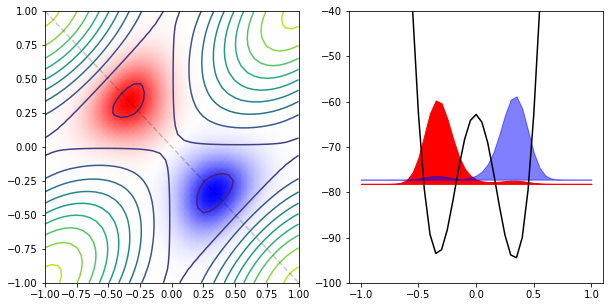

In [222]:
# eigvecs = get_eigvecs(1,0)
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
# plt.figure(figsize=(10,10))
ax[0].contour(phiXX/t.pi,phiYY/t.pi,phi_potential(phiXX,phiYY,1),levels=10)
ax[0].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs[0]).abs()-q_to_phi(eigvecs[1]).abs(),shading='gouraud',cmap="bwr")
ax[0].plot([-1,1],[1,-1],'k--',alpha=0.2)

ax[1].plot(phi/t.pi,phi_potential(phiXX,phiYY,1).T.flip(0).diagonal(),color='k')
ax[1].fill_between(phi/t.pi,eigvals[0],q_to_phi(eigvecs[0]).abs().T.flip(0).diagonal()*5000+eigvals[0],color='r')
ax[1].fill_between(phi/t.pi,eigvals[1],q_to_phi(eigvecs[1]).abs().T.flip(0).diagonal()*5000+eigvals[1],color='b',alpha=0.5)
ax[1].set(ylim=(-100,-40))

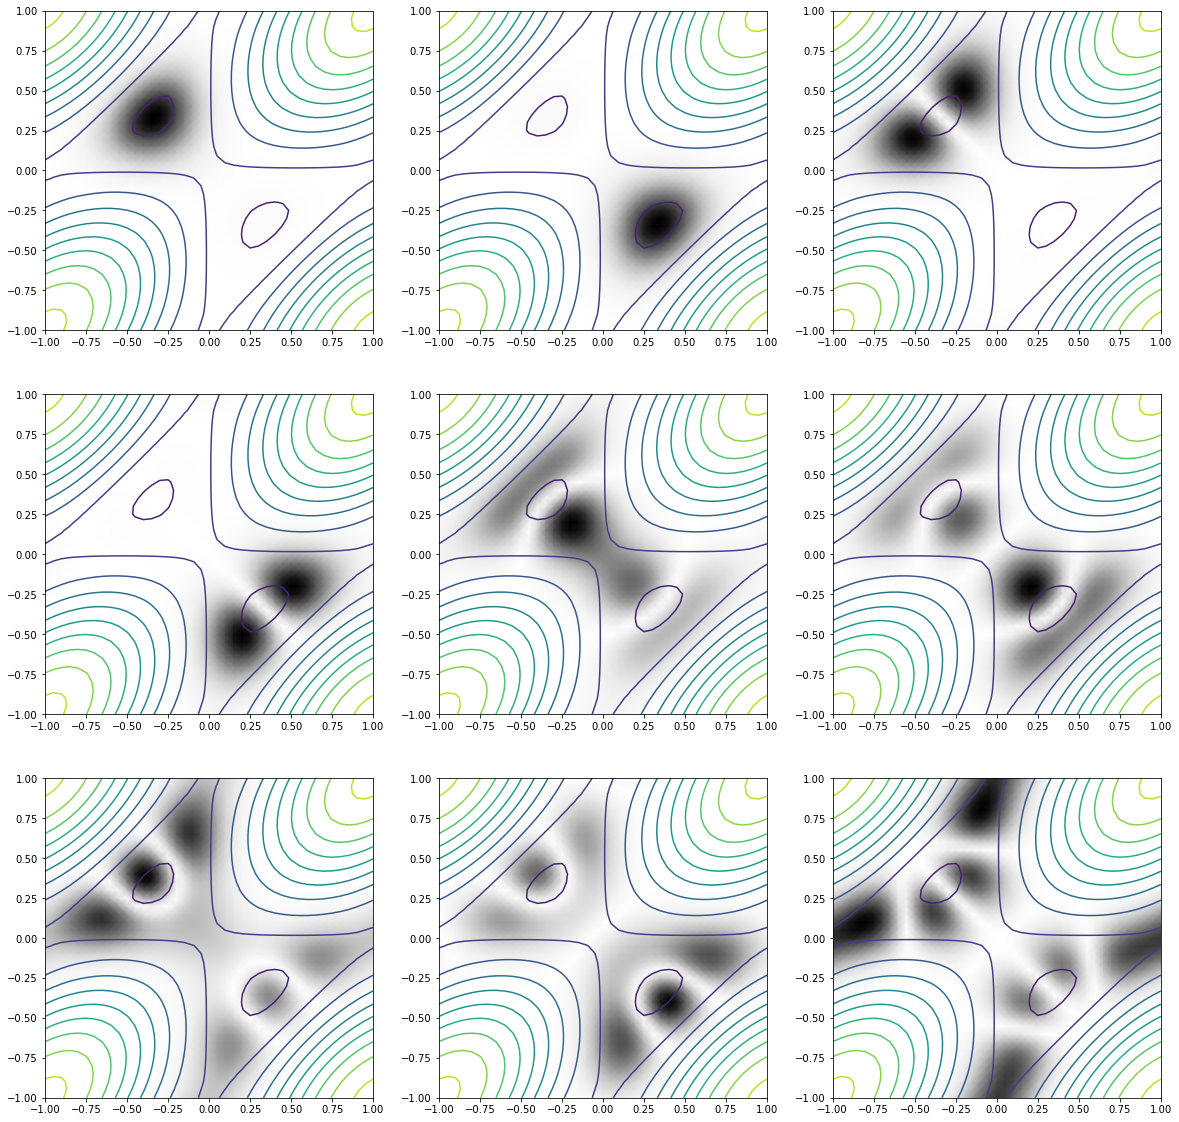

In [179]:
fig, ax = plt.subplots(figsize=(20,20),ncols=3,nrows=3)
ax = ax.flatten()

alpha = 1
eigvecs = get_eigvecs(alpha,0)

for i in range(ax.shape[0]):
    ax[i].contour(phiXX/t.pi,phiYY/t.pi,phi_potential(phiXX,phiYY,alpha),levels=10)
    ax[i].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs[i]).abs(),shading='gouraud',cmap="Greys")

In [257]:
eigvecs1 = get_eigvecs(1,0)
eigvecs05 = get_eigvecs(0.5,0)

C:\Users\jv97\AppData\Local\Temp/ipykernel_28248/2918518391.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX,YY,eigvecs1[9].abs())


(-8.0, 8.0)

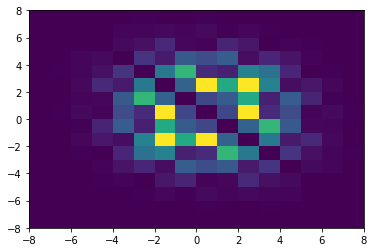

In [264]:
plt.pcolormesh(XX,YY,eigvecs1[9].abs())
plt.xlim(-8,8)
plt.ylim(-8,8)

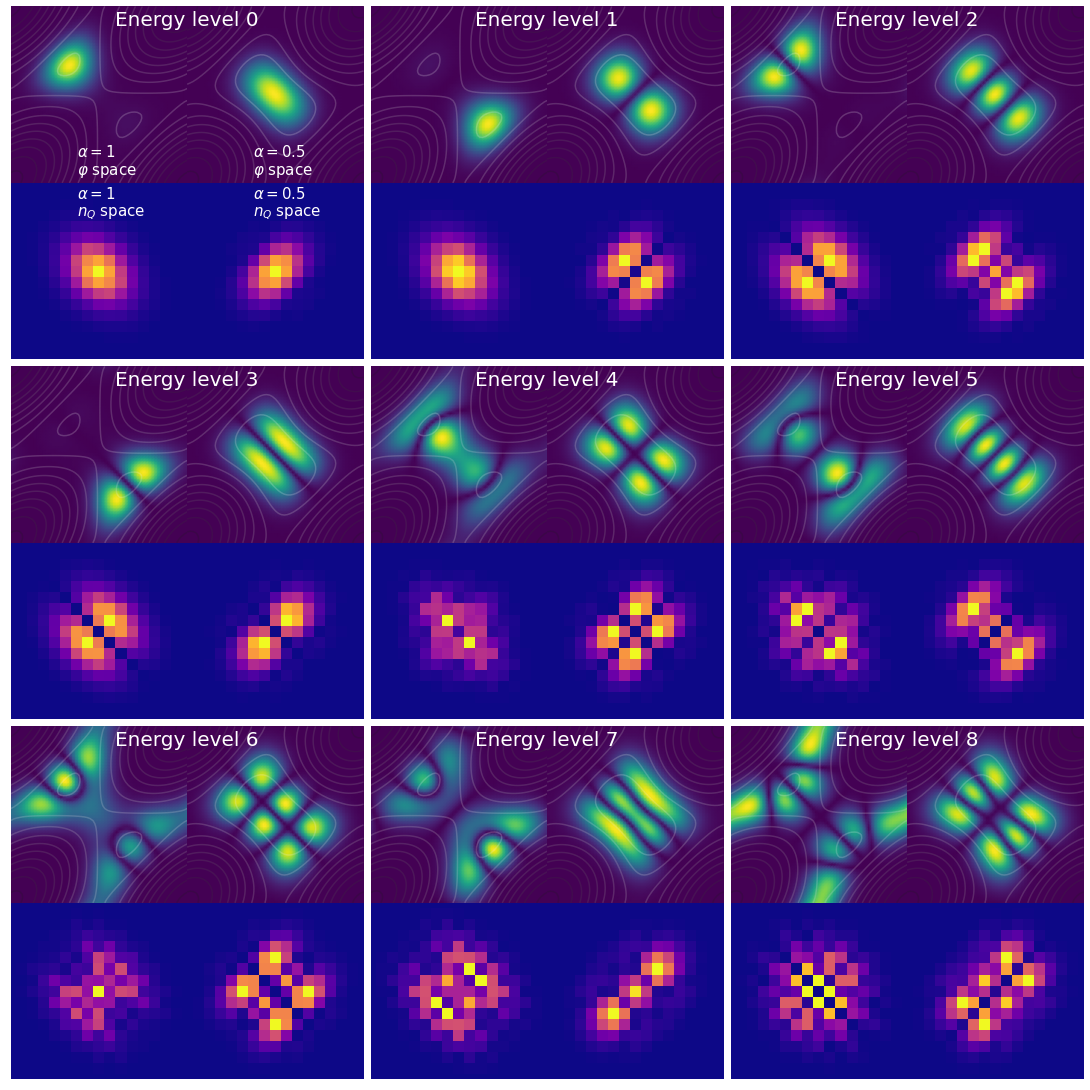

In [333]:
fig = plt.figure(figsize=(15,15))
subfigs = fig.subfigures(3,3)
subfigs = subfigs.flatten()

for i in range(subfigs.shape[0]):
    ax = subfigs[i].subplots(ncols=2,nrows=2,gridspec_kw={'hspace': 0,'wspace': 0},sharex=False,sharey=False)
    if i == 0:
        fontsize=15
        ax[0,0].text(-0.25,-0.9,r"$\alpha=1$"+"\n"+r"$\varphi$ space",color='w',fontsize=fontsize)
        ax[0,1].text(-0.25,-0.9,r"$\alpha=0.5$"+"\n"+r"$\varphi$ space",color='w',fontsize=fontsize)
        ax[1,0].text(-2,5,r"$\alpha=1$"+"\n"+r"$n_Q$ space",color='w',fontsize=fontsize)
        ax[1,1].text(-2,5,r"$\alpha=0.5$"+"\n"+r"$n_Q$ space",color='w',fontsize=fontsize)
    subfigs[i].suptitle(f"Energy level {i}",fontsize=20,color='w')
    ax[0,0].contour(phiXX/t.pi,phiYY/t.pi,phi_potential(phiXX,phiYY,1),levels=10,cmap='Greys',alpha=0.2)
    ax[0,1].contour(phiXX/t.pi,phiYY/t.pi,phi_potential(phiXX,phiYY,0.5),levels=10,cmap='Greys',alpha=0.2)
    ax[0,0].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs1[i]).abs(),shading='gouraud',cmap="viridis")
    ax[0,1].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs05[i]).abs(),shading='gouraud',cmap="viridis")
    ax[1,0].pcolormesh(XX,YY,eigvecs1[i].abs(),shading='nearest',cmap="plasma")
    ax[1,1].pcolormesh(XX,YY,eigvecs05[i].abs(),shading='nearest',cmap="plasma")
    ax[1,0].set(xlim=(-8,8),ylim=(-8,8))
    ax[1,1].set(xlim=(-8,8),ylim=(-8,8))
    # plt.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax[0,0].axis('off')#.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax[0,1].axis('off')
    ax[1,0].axis('off')
    ax[1,1].axis('off')

    

    # ax[0,0].set_title(r"$\alpha=1$ momentum space")
    # ax[0,1].axis('off')
    # ax[1,0].axis('off')
    # ax[1,1].axis('off')
fig.tight_layout()
# subax = subfigs[i].add_axes([0.4,0.4,0.3,0.3])


In [332]:
# fig.savefig("Basis_figs/Orbitals.pdf")

In [335]:
eigvecs104 = get_eigvecs(1,0.4)

In [338]:
q_to_phi(eigvecs1[i])/q_to_phi(eigvecs1[i])

tensor([[1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j],
        ...,
        [1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j],
        [1.+0.j, 1.+0.j, 1.+0.j,  ..., 1.+0.j, 1.+0.j, 1.+0.j]])

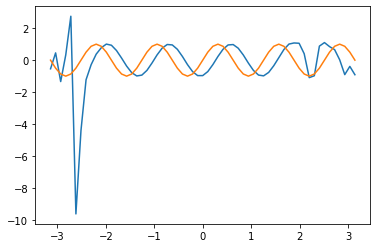

In [361]:
plt.plot(phi,(q_to_phi(eigvecs1[i])/q_to_phi(eigvecs104[i])).real[:,0])
plt.plot(phi,t.sin(5*phi))

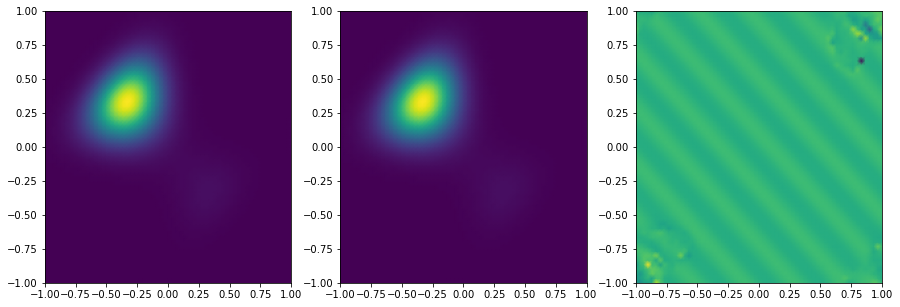

In [362]:
i = 0
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
ax[0].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs1[i]).abs(),shading='gouraud',cmap="viridis")
ax[1].pcolormesh(phiXX/t.pi,phiYY/t.pi,q_to_phi(eigvecs104[i]).abs(),shading='gouraud',cmap="viridis")
ax[2].pcolormesh(phiXX/t.pi,phiYY/t.pi,(q_to_phi(eigvecs1[i])/q_to_phi(eigvecs104[i])).imag,shading='gouraud',cmap="viridis")